For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN, Masking
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model, pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
from matplotlib import animation
from IPython.display import HTML

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score

In [6]:
np.random.seed(42)

In [7]:
n = 50000

In [8]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [9]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)
    

[False False False False  True]


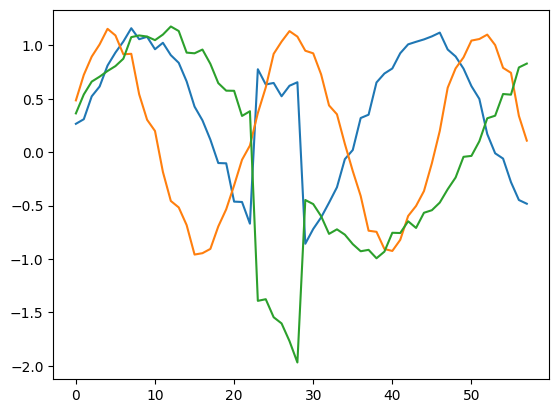

[False False False  True  True]


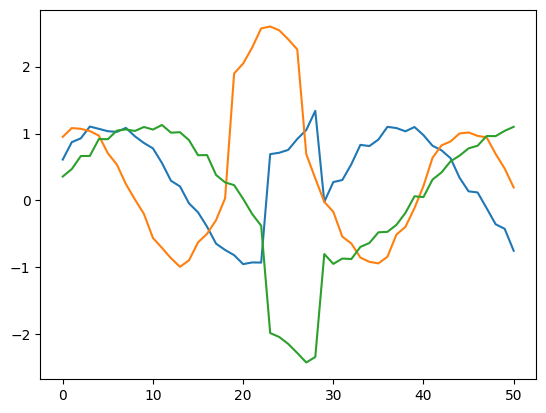

[False False False False False]


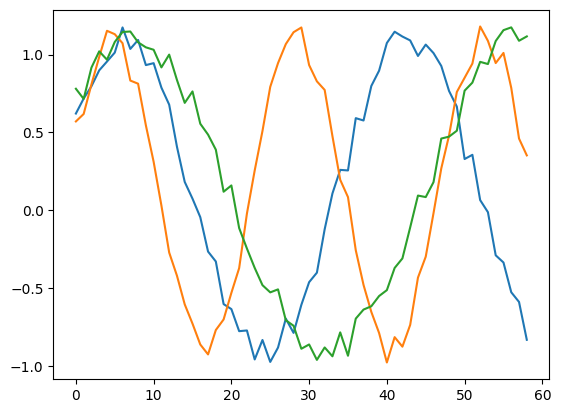

[ True False False False  True]


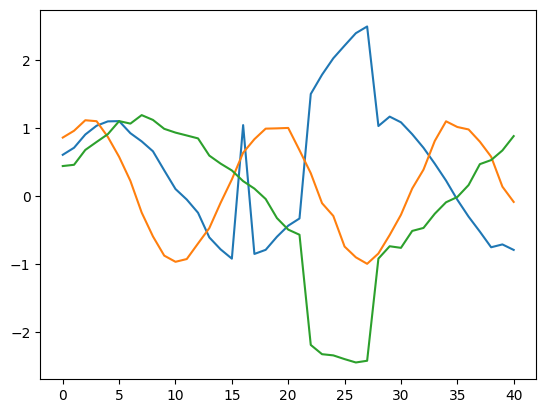

[False  True False False False]


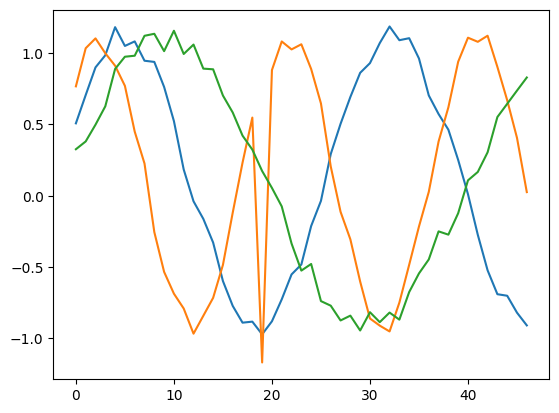

In [10]:
for i in range(5):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

In [158]:
inputLayer = Input(shape=(None,3))
mask = Masking(mask_value=-100)(inputLayer)
lstm = LSTM(5)(mask)
dense1 = Dense(25,activation="relu")(lstm)
#dense2 = Dense(6,activation="relu")(dense1)
outputs = Dense(5,activation="sigmoid")(dense1)
#outputs = [Dense(1,activation="sigmoid")(dense2) for _ in range(yl[0].shape[0])]
model = Model(inputs=inputLayer,outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, None, 3)]         0         
                                                                 
 masking_12 (Masking)        (None, None, 3)           0         
                                                                 
 lstm_33 (LSTM)              (None, 5)                 180       
                                                                 
 dense_160 (Dense)           (None, 25)                150       
                                                                 
 dense_161 (Dense)           (None, 5)                 130       
                                                                 
Total params: 460 (1.80 KB)
Trainable params: 460 (1.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


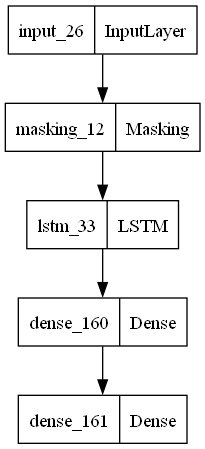

In [159]:
plot_model(model)

In [160]:
x_pad = pad_sequences(xl,dtype='float64',value=-100)
y_arr = np.array(yl)

In [151]:
import random

train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

N = len(x_pad)
train_size,val_size,test_size = int(N*train_frac),int(N*val_frac),int(N*test_frac)
data_idx = list(range(N))
random.shuffle(data_idx)
train_idx,test_idx,val_idx = data_idx[:train_size],data_idx[-test_size:],data_idx[train_size+1:train_size+val_size]
X_train,y_train = x_pad[train_idx],y_arr[train_idx]
X_test,y_test = x_pad[test_idx],y_arr[test_idx]
X_val,y_val = x_pad[val_idx],y_arr[val_idx]

In [161]:
early = EarlyStopping(patience=7, restore_best_weights=True)
model.fit(X_train,y_train, batch_size=64, epochs=20, callbacks=[early])

Epoch 1/20
625/625 [==============================] - 10s 12ms/step - loss: 0.5687 - accuracy: 0.1838
Epoch 2/20
625/625 [==============================] - 8s 13ms/step - loss: 0.4822 - accuracy: 0.2116
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.4524 - accuracy: 0.3457
Epoch 4/20
625/625 [==============================] - 7s 11ms/step - loss: 0.4294 - accuracy: 0.4653
Epoch 5/20
625/625 [==============================] - 8s 12ms/step - loss: 0.4125 - accuracy: 0.4835
Epoch 6/20
625/625 [==============================] - 8s 12ms/step - loss: 0.3750 - accuracy: 0.4887
Epoch 7/20
625/625 [==============================] - 9s 15ms/step - loss: 0.3444 - accuracy: 0.4997
Epoch 8/20
625/625 [==============================] - 7s 12ms/step - loss: 0.3319 - accuracy: 0.4985
Epoch 9/20
625/625 [==============================] - 11s 18ms/step - loss: 0.3238 - accuracy: 0.5040
Epoch 10/20
625/625 [==============================] - 9s 14ms/step - loss: 0.3167 - accu

In [162]:
y_pred = model.predict(X_test)

157/157 [==============================] - 2s 6ms/step


In [164]:
model.evaluate(X_test,y_test)

157/157 [==============================] - 2s 5ms/step - loss: 0.2776 - accuracy: 0.5012


[0.2775861918926239, 0.5012000203132629]